In [57]:
# https://teddykoker.com/2022/04/learning-to-learn-jax/

In [58]:
!pip install optax flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp
from jax import random
import jax
import optax
import flax
from flax import linen as nn
import time

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt


#**Data**

In [60]:
data_dir = '/tmp/tfds'

mnist_data, info = tfds.load(name="mnist", data_dir=data_dir, batch_size=-1, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes


# **Utility**

In [61]:
# DATA 
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [62]:
# MODEL 

## INICIALIZA UMA CAMADA DENSA
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

## INICIALIZA A REDE 
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## SEPARA OS DADOS DE TREINAMENTO E TESTE EM BATCHES
def get_train_batches(x,y,batch_size):
  return zip(jnp.array_split(x,batch_size),jnp.array_split(y,batch_size))

## FUNÇÃO DE SCORE DE TREINAMENTO 
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

## FUNÇÃO DE PERDA
def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

## FUNÇÃO DE ATUALIZAÇÃO DE PARAMETROS 
@jit
def update(params,step_size, x, y): 
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

## FUNÇÃO DE ATIVAÇÃO RELU
def relu(x):
  return jnp.maximum(0, x)

## FUNÇÃO DE SAÍDA DE PREDIÇÃO
def predict(params, image):
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b 
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

## FUNÇÃO DE PREDIÇÃO POR BATCH
batched_predict = vmap(predict, in_axes=(None, 0))

## FUNÇÃO DE TREINAMENTO
def train(num_epochs,train,test,num_labels,batch_size,step_size,params):
  for epoch in range(num_epochs):
    start_time = time.time()
    for x, y in get_train_batches(train[0],train[1],batch_size):
      params = update(params,step_size, x, y)

    epoch_time = time.time() - start_time
    
    train_acc = accuracy(params, train[0],train[1])
    test_acc = accuracy(params, test[0],test[1])
    print(f"Epoch {epoch} in {epoch_time:0.2f} sec -> Training set accuracy {train_acc} - Test set accuracy {test_acc}")
  return params

# **Model**

## **Separação dos dados**

In [63]:
h, w, c = info.features['image'].shape
num_pixels = h * w * c

print(f'Numero de pixels:{num_pixels}')
print(f'h = {h}, w = {w}, c = {c}')

Numero de pixels:784
h = 28, w = 28, c = 1


In [64]:
# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)


## **Treinamento do modelo**

In [65]:
## PARAMETROS
layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10

In [66]:
# TREINAMENTO
params = init_network_params(layer_sizes, random.PRNGKey(0))
params = train(num_epochs = num_epochs,
               train =(train_images,train_labels),
               test = (test_images,test_labels),
               num_labels = num_labels,
               batch_size = batch_size,
               step_size = step_size,
               params = params)

Epoch 0 in 5.97 sec -> Training set accuracy 0.885616660118103 - Test set accuracy 0.8912000060081482
Epoch 1 in 7.80 sec -> Training set accuracy 0.9084833264350891 - Test set accuracy 0.9095999598503113
Epoch 2 in 10.99 sec -> Training set accuracy 0.9197166562080383 - Test set accuracy 0.921999990940094
Epoch 3 in 4.35 sec -> Training set accuracy 0.927566647529602 - Test set accuracy 0.9291999936103821
Epoch 4 in 4.45 sec -> Training set accuracy 0.9334333539009094 - Test set accuracy 0.9328999519348145
Epoch 5 in 3.85 sec -> Training set accuracy 0.9379166960716248 - Test set accuracy 0.936199963092804
Epoch 6 in 5.18 sec -> Training set accuracy 0.9422833323478699 - Test set accuracy 0.9405999779701233
Epoch 7 in 3.85 sec -> Training set accuracy 0.9455500245094299 - Test set accuracy 0.9436999559402466
Epoch 8 in 3.88 sec -> Training set accuracy 0.9488500356674194 - Test set accuracy 0.9469999670982361
Epoch 9 in 5.15 sec -> Training set accuracy 0.9511666893959045 - Test set a

# **Teste do modelo**

In [67]:
## PREDIÇÃO
batched_preds = batched_predict(params, test_images)

In [68]:
## ACURACIA
accuracy(params, test_images, test_labels)

Array(0.9486, dtype=float32)

In [69]:
for i in range(10):
  print(f"""Predict:{jnp.argmax(batched_preds[i])} Label true:{jnp.argmax(test_labels[i])}""")

Predict:2 Label true:2
Predict:0 Label true:0
Predict:4 Label true:4
Predict:8 Label true:8
Predict:7 Label true:7
Predict:6 Label true:6
Predict:0 Label true:0
Predict:6 Label true:6
Predict:3 Label true:3
Predict:1 Label true:1


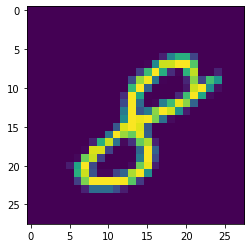

In [70]:
imgplot = plt.imshow(test_images[3].reshape(h, w, c))
plt.show()